# Load Packages and Data

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import sys
import time

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import normalize
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

%matplotlib inline

In [2]:
df = pd.read_csv('dm_dat.csv')
print df.shape

# Drop obs with null value in title or pub_time
df = df[df['title'].notnull()]
print df.shape
df = df[df['pub_time'].notnull()]
print df.shape

# Reset index - much quicker to do it here than once I've made tf-idf matrix
df = df.reset_index()

(54978, 14)
(54977, 14)
(54943, 14)


Let's explore the distributions of shares and comments, and drop outliers.

In [3]:
print 'No shares:', sum(df['shares']==0)*100/float(len(df))
print 'No comments:', sum(df['comments']==0)*100/float(len(df))

print '>1500 shares:', sum(df['shares']>1500)*100/float(len(df))
print '>300 comments:', sum(df['comments']>300)*100/float(len(df))
print '>1500 shares or >300 comments:',sum((df['shares']>1500) | (df['comments']>300))*100/float(len(df))
df = df[(df['shares']<=1500) & (df['comments']<=300)]
df = df.reset_index()

No shares: 57.3339642903
No comments: 52.6764100977
>1500 shares: 5.88792020822
>300 comments: 5.03248821506
>1500 shares or >300 comments: 8.89103252462


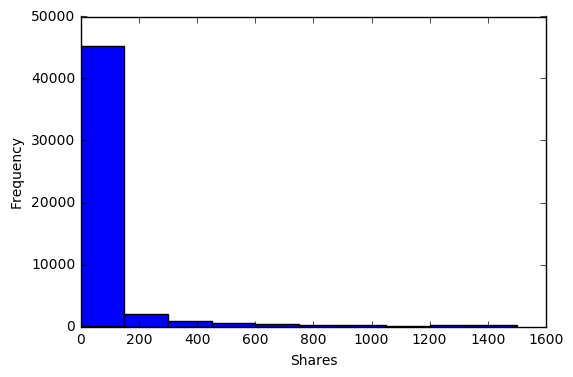

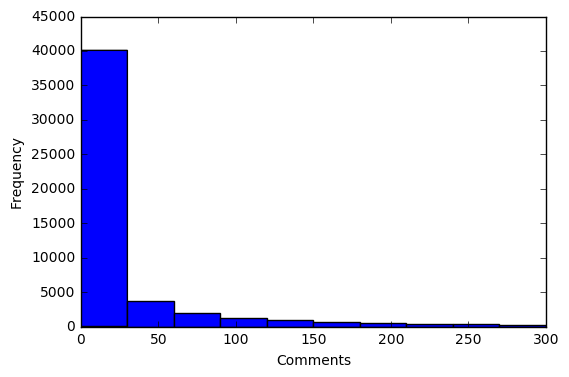

In [5]:
plt.hist(df['shares'].tolist())
plt.xlabel("Shares")
plt.ylabel("Frequency")
plt.show()
plt.hist(df['comments'].tolist())
plt.xlabel("Comments")
plt.ylabel("Frequency")
plt.show()

# Preprocess Non-Text Features

Create dummy variables for key categories.

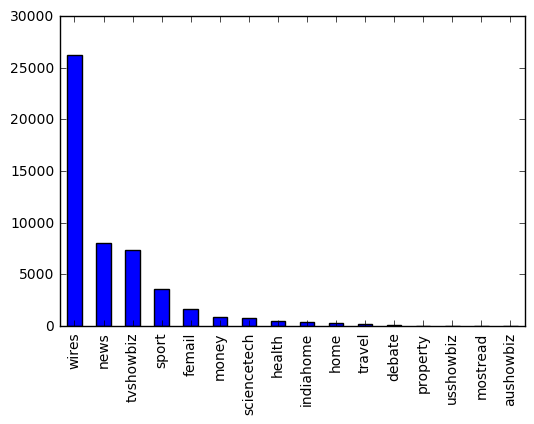

In [5]:
df.category.value_counts().plot(kind='bar')
pop_cats = ['wires', 'news', 'tvshowbiz', 'sport', 'femail']
for c in pop_cats:
    df['cat_' + c] = 0
    df.loc[df.category==c, 'cat_' + c] = 1

# Preprocess Text Data

I need to convert the data from the titles into numerical features. To do this, I will create a TF-IDF matrix. In the process, I will in the following order (although note that there are multiple ways in which these operations could be combined):
<ol>
<li>**Remove all non-ASCII characters**: eg. \xe2\x80\x98</li>
<li>**Make all words lowercase**</li>
<li>**Remove punctuation**</li>
<li>***Tokenize***: divide string into a list of substrings.</li>
<li>**Remove words not containing letters**
<li>**Remove words containing numbers**
<li>**Remove stopwords**: stopwords are a list of high frequency words like, the, to, and also.</li>
<li>**Stem**: take the root of each word.</li>
<li>**Remove short words**: that is, of 3 characters or less.</li>
</ol>

I will carry out all but the first of these steps in the process of creating a TF-IDF matrix, below. But we need to prepare the functions beforehand.

In [6]:
def no_punctuation_unicode(text):
    '''.translate only takes str, whereas TfidfVectorizer only takes unicode.
    Therefore, to use .translate in the tokenizer in TfidfVectorizer I need to
    write a function that converts unicode -> string, applies .translate,
    and then converts it back'''
    str_text = str(text)
    no_punctuation = str_text.translate(None, string.punctuation)
    unicode_text = no_punctuation.decode('utf-8')
    return unicode_text

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def prep_blurb(text):
    lowers = text.lower()
    no_punct = no_punctuation_unicode(lowers)
    tokens = nltk.word_tokenize(no_punct)
    has_letters = [t for t in tokens if re.search('[a-zA-Z]',t)]
    no_numbers  = [t for t in has_letters if not hasNumbers(t)]
    drop_stops = [w for w in no_numbers if not w in stoplist] 
    stems = [stemmer.stem(t) for t in drop_stops]
    drop_short = [s for s in stems if len(s)>2]
    return drop_short

I next extract a matrix of TF-IDF (term frequency-inverse document frequency) features.

The tf-idf weight of a term in a document is the product of its tf (term frequency) weight and its idf (inverse document frequency) weight. This is generally given by the formula:

$w_{t,d} = (1 + logtf_{t,d}) \times log_{10}(\frac{N}{df_t})$

Where the term frequency $tf_{t,d}$ of term t in document d is defined as the number of times that t occurs in d, the document frequency $df_t$ is he number of documents that contain t, and N is the number of documents. The computation of tf-idfs in scikit-learn is in fact [slightly different from the standard textbook notation](http://scikit-learn.org/dev/modules/feature_extraction.html#the-bag-of-words-representation), but we can ignore that here.

The tf-idf weight (of a term in a document) thus increases with the number of times a term occurs in a document, and also increases with the rarity of the term in the collection.

I will specify some key parameters I define in ```TfidfVectorizer```:
<ul>
<li> max_df: ignore terms that have a document frequency strictly higher than the given threshold (eg. ignore words that appear in more than .8 of documents).
<li> min_idf:  ignore terms that have a document frequency strictly lower than the given threshold (eg. ignore words that occure in less than .2 of the documents).
<li> norm: I use [L2 normalization](http://stats.stackexchange.com/questions/225564/scikit-learn-normalization-mode-l1-vs-l2-max) following an [scikit-learn example](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py) that I draw on later in my Lasso analysis. (I originally tried standardizing the dense datframe I created from the sparse matrix such that every predictor would have mean=0 and sd=1, following a different [Lasso example on Coursera](https://www.coursera.org/learn/machine-learning-data-analysis/home/welcome), but this was taking forever to run.)
</ul>

The following cell takes a while to run.

In [7]:
# Get list of titles
tlist = df['title'].tolist()

##Remove all non-ASCII characters from titles
new_list = []
for t in tlist:
    new_list.append(t.decode('utf8').encode('ascii', errors='ignore'))
tlist = new_list
    
# Convert items in alist, as TfidfVectorizer only takes unicode
tlist = [t.decode('utf-8') for t in tlist]

# Stopwords must also be in unicode to work with TfidfVectorizer
stoplist = [word.decode('utf-8') for word in nltk.corpus.stopwords.words('english')] 

# Create stemmer
stemmer = SnowballStemmer("english")

# Don't use stop_words argument to TfidfVectorizer as delt with in prep_blurb
tfidf_vectorizer = TfidfVectorizer(tokenizer=prep_blurb, min_df=0.01, norm='l2')
%time tf_idf = tfidf_vectorizer.fit_transform(tlist)

print 'Length initial list:', len(tlist)
print 'tf_idf.shape:', tf_idf.shape
print 'type(tf_idf):', type(tf_idf)

list_of_words = tfidf_vectorizer.get_feature_names()
print 'List of words:', list_of_words[:50]

CPU times: user 1min 4s, sys: 749 ms, total: 1min 5s
Wall time: 1min 30s
Length initial list: 50058
tf_idf.shape: (50058, 104)
type(tf_idf): <class 'scipy.sparse.csr.csr_matrix'>
List of words: [u'ahead', u'arrest', u'attack', u'babi', u'back', u'ban', u'bank', u'boss', u'call', u'car', u'celebr', u'championship', u'charg', u'china', u'citi', u'claim', u'could', u'court', u'cup', u'cut', u'daughter', u'day', u'dead', u'deal', u'death', u'die', u'dress', u'end', u'england', u'face', u'famili', u'fan', u'fashion', u'fight', u'fire', u'first', u'forc', u'former', u'get', u'girl', u'give', u'head', u'help', u'high', u'hit', u'home', u'hous', u'husband', u'kill', u'latest']


Trying different values of min_df df and max_df it becomes clear that the vast majority of words appear in less than 1 percent of documents, while very few words appear in a high proportion of documents. I choose to ignore all words that appear in less than 1 percent of documents. 

Extracting tf-idf features, above, gives us a weight matrix between terms and documents. Each document is represented by a row of the matrix, which is a real valued vector, and each term by a column. This will be a sparse matrix, that is, a matrix in which most of the elements are zero.

scikit-learn's TfidfVectorizer returns a matrix in scipy.sparse.csr format. Printing this matrix shows the nonzero values of the matrix in the (row, col) format. 

In [8]:
print 'tf_idf[:2,]:', tf_idf[:2,]

tf_idf[:2,]:   (0, 91)	0.73451170983
  (0, 74)	0.678596012457
  (1, 75)	1.0


In order to include the features from my TF-IDF matrix in my regression model, I need to convert my scipy sparse matrix to a regular dataframe. 

In [9]:
print tf_idf.shape
df_tfidf = pd.DataFrame(tf_idf.todense())
print tf_idf.shape
df_tfidf.columns = list_of_words

(50058, 104)
(50058, 104)


I next need to attach my tf-idf matrix dataframe to the other predictor variables. In Lasso regression, the penalty term is not fair if the predictor variables are not on the same scale, as this would mean that not all of the predictors get the same penalty. I normalized the variables in my tf-idf matrix already, and I now need to normalize the non-text variables (I originally tried standardizing, but this was extremely slow - see above discussion of paramaters in TfidfVectorizer).

In [10]:
df_notext = df[['pub_days', 'pub_dayofweek', 'pub_sincemid', 'sponsored_dummy', 
                 'cat_wires', 'cat_news', 'cat_tvshowbiz', 'cat_sport', 'cat_femail']]
df_notext_1 = pd.DataFrame(normalize(df_notext, norm='l2', copy=False, axis=0))  #axis=0 normalizes each column
df_notext_1.columns = df_notext.columns.values
df_notext = df_notext_1
del df_notext_1
df_notext.head(3)

,pub_days,pub_dayofweek,pub_sincemid,sponsored_dummy,cat_wires,cat_news,cat_tvshowbiz,cat_sport,cat_femail
0,0.0,0.001371,0.003118,0.0,0.006175,0.0,0.0,0.0,0.0
1,0.0,0.001371,0.003416,0.0,0.006175,0.0,0.0,0.0,0.0
2,0.0,0.001371,0.003190,0.0,0.006175,0.0,0.0,0.0,0.0


In joining my tf-idf dataframe with the other variables, concatenating and merging is extremely slow. The quickest approach seems to be to create an empty column for each variable I want to add, and then fill it with the appropriate values.

In [11]:
for c in df_notext.columns.values.tolist():
    df_tfidf[c] = np.nan
    df_tfidf[c] = df_notext[c]

Finally, I need to make sure that I have joined each tf-idf row with the correct values of the other variables (ie. that I have joined all text features to the appropriate observation).

If I try selecting multiple columns from a row of df_tfidf, with a large dataframe it ends up sucking up loads of memory and can grind to a hault (this occured when I didn't restrict my tf-idf matrix to words that appeared at least one percent of the time). I believe that problem is that [pandas returns copies for most operations](http://stackoverflow.com/questions/25196595/memory-optimization-when-selecting-from-a-pandas-dataframe). Therefore, I'm better of selecting a row and then examing that. 

In [12]:
print df.ix[0]['title']
test_row = df_tfidf.iloc[0]
test_row[test_row>0]

Russia says Trump's efforts on Ukraine better than Obama's - TASS


say              0.678596
trump            0.734512
pub_dayofweek    0.001371
pub_sincemid     0.003118
cat_wires        0.006175
Name: 0, dtype: float64

## Lasso Regression

I employ Lasso Regression, as I have a large number of predictors. Lasso is a shrinkage method for linear regression models that selects the predictors to include. The Lasso imposes a constraint on the sum of the absolute values of the model parameters, where the sum has a specified constant as an upper bound. This contraint causes regression coefficients for some coefficients to shrink towards zero. This is the shrinkage process, which allows for better interpetation of the model and identifies the variables most strongly asssociated with the outcome of the model.

\begin{align*}
\hat{\beta}^{lasso} &= argmin_\beta\sum_{i=1}^N\big(y_i - \beta_0 - \sum_{j=1}^px_{ij}\beta_j\big)^2 \\
&s.t. \sum_{j=1}^p|\beta_j| \leq t
\end{align*}

Alternatively, we the model can be written as:

\begin{equation*}
\hat{\beta}^{lasso} = \Big\{argmin_\beta\frac{1}{2}\sum_{i=1}^N\big(y_i - \beta_0 - \sum_{j=1}^px_{ij}\beta_j\big)^2 + \lambda\sum_{j=1}^p|\beta_j|\Big\}
\end{equation*}

Below, we will use cross-validation to choose the penalty parameter, $\lambda$. I developed the code below from a [scikit-learn example](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py) and a [Coursera example](https://www.coursera.org/learn/machine-learning-data-analysis/lecture/0PTeX/data-management-for-lasso-regression-in-python).

Decide whether to look at shares or comments as outcome. Here I will report the results for shares, but the results for comments are similar.

In [13]:
y = 'shares'
# y = 'comments'

Split the data into a training and test set. (With a larger dataframe, ```train_test_split``` makes the memory usage blow up. StackerOverflow has [instructions for getting around this](http://stackoverflow.com/questions/31467487/memory-efficient-way-to-split-large-numpy-array-into-train-and-test).)

In [14]:
pred_train, pred_test, tar_train, tar_test = train_test_split(df_tfidf.as_matrix(), df[y].as_matrix(),
                                                              test_size=.2, random_state=123)

Specify the lasso regression model. I will use the least angle regression (LAR) algorithm to fit the model, and will use cross-validation to select the value of the penalty parameter. Note the scikit-learn calls this penalty parameter $\alpha$, but the more conventional term is $\lambda$.

In [15]:
t1 = time.time()
model=LassoLarsCV(cv=10, precompute=False).fit(pred_train, tar_train)
t_lasso_lars_cv = time.time() - t1
print 'train time (seconds):', t_lasso_lars_cv

train time (seconds): 139.055151939


Plot mean square error for each fold.

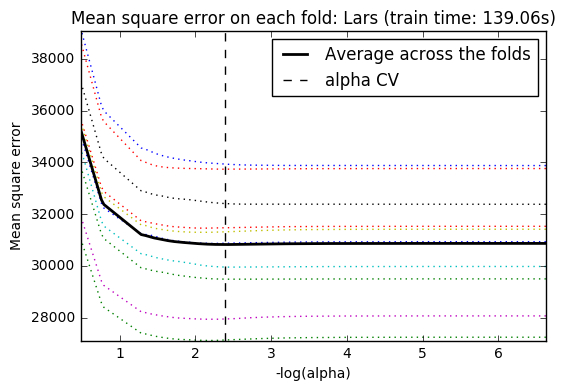

In [16]:
m_log_alphas = -np.log10(model.cv_alphas_)

plt.figure()
plt.plot(m_log_alphas, model.cv_mse_path_, ':')
plt.plot(m_log_alphas, model.cv_mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: Lars (train time: %.2fs)'
          % t_lasso_lars_cv)
plt.axis('tight')
plt.show()

Print variable names and regression coefficients

In [17]:
import operator
coefs = dict(zip(df_tfidf.columns, model.coef_))
coefs = { k:v for k, v in coefs.items() if v!=0 }
print 'Initial number coefs:', df_tfidf.shape[1]
print 'Coefs after fitting model:', len(coefs)
#sorted_coefs_abs = sorted(coefs.items(), key=lambda x:-abs(x[1]))
#sorted_coefs_abs
sorted_coefs = sorted(coefs.items(), key=lambda x:-x[1])
sorted_coefs[:20]

Initial number coefs: 113
Coefs after fitting model: 61


[('cat_news', 6457.1089767405892),
 ('cat_sport', 2338.9548679840141),
 ('cat_femail', 2194.3944872910138),
 ('pub_dayofweek', 674.05328166277548),
 (u'fan', 67.344754789220843),
 (u'mother', 42.871103821600506),
 (u'result', 30.39223099714831),
 (u'die', 28.563209732589247),
 (u'could', 25.716163788410302),
 (u'leagu', 18.913882332635978),
 (u'day', 17.1794994384285),
 (u'citi', 14.415228738122297),
 (u'hit', 13.715704444634861),
 (u'dead', 12.913204844870688),
 (u'reveal', 11.143245395084916),
 (u'woman', 11.018106167138564),
 (u'take', 7.9141906048904103),
 (u'show', 7.6991464475243729),
 (u'kill', 6.6831222637873049),
 (u'first', 6.4862336765768669)]

In [18]:
sorted_coefs[-20:]

[(u'deal', -4.5588244435341938),
 (u'court', -5.6793259254106188),
 (u'win', -6.2947798170565221),
 (u'dress', -6.8887285606274187),
 (u'south', -7.0223257334048759),
 (u'share', -8.0188266404071964),
 (u'rise', -8.1114480059738501),
 (u'cut', -10.247472504079557),
 (u'bank', -10.691355169141501),
 (u'celebr', -12.020082541922447),
 (u'fashion', -12.176155312845649),
 (u'nation', -15.435111782993314),
 (u'husband', -18.05404733809252),
 (u'man', -20.018031968860008),
 (u'car', -28.865403158590983),
 (u'championship', -32.505194129960678),
 (u'england', -61.764827038359272),
 ('pub_days', -265.29318651590592),
 ('pub_sincemid', -1006.3057846628965),
 ('cat_wires', -13891.352753144545)]

How does model do no test data?

In [93]:
def print_errors(model, pred_train, pred_test, tar_train, tar_test):
    # MSE from training and test data
    train_error = mean_squared_error(tar_train, model.predict(pred_train))
    test_error = mean_squared_error(tar_test, model.predict(pred_test))
    print ('training data MSE')
    print(train_error)
    print ('test data MSE')
    print(test_error)
    print

    # MAE from training and test data
    train_error = mean_absolute_error(tar_train, model.predict(pred_train))
    test_error = mean_absolute_error(tar_test, model.predict(pred_test))
    print ('training data MAE')
    print(train_error)
    print ('test data MAE')
    print(test_error)
print_errors(model, pred_train, pred_test, tar_train, tar_test)

How large is this error in context of data?

In [20]:
print min(df[y])
print max(df[y])
print np.std(df[y])

0
1500
189.291839447


How does this compare to fitting model without text variables?

In [21]:
pred_train, pred_test, tar_train, tar_test = train_test_split(df_notext.as_matrix(), df[y].as_matrix(),
                                                              test_size=.2, random_state=123)

t1 = time.time()
model=LassoLarsCV(cv=20, precompute=False).fit(pred_train, tar_train)
t_lasso_lars_cv = time.time() - t1
print 'trains time (seconds):', t_lasso_lars_cv
print

# Number of coefs after fitting model
coefs = dict(zip(df_notext.columns, model.coef_))
print 'Initial number coefs:', df_notext.shape[1]
print 'Coefs after fitting model:', len(coefs)
print

# MSE and MAE
print_errors(model, pred_train, pred_test, tar_train, tar_test)

trains time (seconds): 2.90709996223

Initial number coefs: 9
Coefs after fitting model: 9

training data MSE
30891.4842252
test data MSE
33684.8088984

training data MSE
76.1813939733
test data MSE
79.182473179


This is rather disappointing. Including text features does not improve the predictive power of our model. This likely results, at least in part, from the fact that such a high proportion of words occur in less than 1 percent of the document titles. 

## Create Features Using K-Means

Previous research as found that clustering at the preprocessing stage can help to reduce predictive error; for example, [Trivedi, Pardos, and Heffernan (2015)](https://arxiv.org/pdf/1509.06163.pdf). If this worked in this context, it would have the added advantage of allowing us to more meaninfully interpret our model; for example, we might be able to say that articles discussing soccer victories are particularly widely shared.

I will use k-means to cluster articles at the pre-processing stage, and then include these clusters as predictors in a regression model. Starting with k cluster centers, k-means identifies which points are nearest to each cluster center. It then chooses new cluster centers by minimizing the total quadratic distance of each cluster center to its points. Then it repeats this process, starting with these new cluster centers.

My dataframe is already to some extent grouped by topic according to the category variable. I will use k-means clustering for only the two largest of these groups: news and wires. I therefore need to attach an id variable to my dataframe so that I don't loose track of these observations, and then take only the news and wires stories. Note that non of the following code is going to work, absent a huge amount of RAM, with a very big dataset.

In [97]:
df_tfidf['article_id'] = np.nan
df_tfidf['article_id'] = df['article_id']

In [98]:
df_tfidf.columns.values

array([u'ahead', u'arrest', u'attack', u'babi', u'back', u'ban', u'bank',
       u'boss', u'call', u'car', u'celebr', u'championship', u'charg',
       u'china', u'citi', u'claim', u'could', u'court', u'cup', u'cut',
       u'daughter', u'day', u'dead', u'deal', u'death', u'die', u'dress',
       u'end', u'england', u'face', u'famili', u'fan', u'fashion',
       u'fight', u'fire', u'first', u'forc', u'former', u'get', u'girl',
       u'give', u'head', u'help', u'high', u'hit', u'home', u'hous',
       u'husband', u'kill', u'latest', u'lead', u'leagu', u'leav', u'life',
       u'like', u'look', u'love', u'make', u'man', u'meet', u'mother',
       u'nation', u'new', u'one', u'open', u'parti', u'plan', u'polic',
       u'presid', u'report', u'result', u'return', u'reveal', u'rise',
       u'say', u'see', u'set', u'share', u'show', u'son', u'south',
       u'stand', u'star', u'state', u'take', u'talk', u'test', u'three',
       u'time', u'top', u'tri', u'trump', u'two', u'use', u'want', u'

In [99]:
df_1 = df_tfidf[(df_tfidf['cat_news']>0) | (df_tfidf['cat_wires']>0)]

I next need to drop non-text variables from dataframe I will use for clustering, as I only want to cluster by text features. Also drop the id variable, but keep this vector for later.

In [100]:
df_1 = df_1.drop(df_notext.columns.values.tolist(), axis=1)   # get warning if do it inplace
df_1_id = df_1['article_id']
df_1.drop('article_id', axis=1, inplace=True)
df_1.columns.values

array([u'ahead', u'arrest', u'attack', u'babi', u'back', u'ban', u'bank',
       u'boss', u'call', u'car', u'celebr', u'championship', u'charg',
       u'china', u'citi', u'claim', u'could', u'court', u'cup', u'cut',
       u'daughter', u'day', u'dead', u'deal', u'death', u'die', u'dress',
       u'end', u'england', u'face', u'famili', u'fan', u'fashion',
       u'fight', u'fire', u'first', u'forc', u'former', u'get', u'girl',
       u'give', u'head', u'help', u'high', u'hit', u'home', u'hous',
       u'husband', u'kill', u'latest', u'lead', u'leagu', u'leav', u'life',
       u'like', u'look', u'love', u'make', u'man', u'meet', u'mother',
       u'nation', u'new', u'one', u'open', u'parti', u'plan', u'polic',
       u'presid', u'report', u'result', u'return', u'reveal', u'rise',
       u'say', u'see', u'set', u'share', u'show', u'son', u'south',
       u'stand', u'star', u'state', u'take', u'talk', u'test', u'three',
       u'time', u'top', u'tri', u'trump', u'two', u'use', u'want', u'

Then fit model. I tried different numbers of clusters, 6 clusters gives the most meaningful groupings.

In [101]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
%time km = kmeans.fit(df_1)

CPU times: user 11.3 s, sys: 195 ms, total: 11.5 s
Wall time: 6.88 s


I next want to look at some of the text in my different clusters to see if it seems reasonable. 

In a good clustering of documents:
* Documents in the same cluster should be similar.
* Documents from different clusters should be less similar.

To examine the text in my clustering I will:
* Fetch 5 nearest neighbors of each centroid from the set of documents assigned to that cluster. I will consider these documents as being representative of the cluster.
* Print top 5 words that have highest tf-idf weights in each centroid.

In [102]:
centroids = km.cluster_centers_   # coordinates of cluster centers
cluster_assignment = km.labels_   # label of every data point

for c in xrange(n_clusters):
    # Cluster heading
    print('Cluster {0:d}    '.format(c))

    # Print top 5 words with largest TF-IDF weights in the cluster
    idx = centroids[c].argsort()[::-1]
    for i in xrange(5):
        print list_of_words[idx[i]], centroids[c,idx[i]]
    print ('')
    
    # Compute distances from the centroid to all data points in the cluster
    distances = pairwise_distances(tf_idf, [centroids[c]], metric='euclidean').flatten()
    distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
    nearest_neighbors = distances.argsort() # argsort() returns the indices that would sort an array
    # For 5 nearest neighbors, print the first 250 characters of text
    for i in xrange(5):
        print tlist[nearest_neighbors[i]][:250]
        print ('')
    print('==========================================================')

Cluster 0    
new 0.676215639123
south 0.0329973543237
say 0.0268965803513
deal 0.0241164035692
home 0.0191492984279

PSA unveils new DS7 Crossback sport utility vehicle

Katy Perry rocks vibrant pink suit in promo shots for her new single... after admitting she has 'given up' caring what people think about her style

Kristen Stewart jets out of LA after creating a real buzz with her new shaved hairdo

The Talented Mr Damon: Boston native Matt will narrate a new documentary about the marathon bombing in his hometown

European rights official denounces new Hungarian asylum law

Cluster 1    
win 0.0212595767793
china 0.019911651449
polic 0.0199069152434
top 0.0144398629067
back 0.014095267931

Hoges: The Paul Hogan Story rates behind music biopics INXS and Molly with 1.32M viewers

Fraudster posed as Nickelback's drummer in a bid to swindle $25,000 worth of high-end microphones

Ex-deputy accused of sexually assaulting female inmates

Turkey's treatment of journalist damaging German-Tur

/Users/sambarrows/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 50058 but corresponding boolean dimension is 34299


These clusterings are far from perfect. For one thing, some clusterings appear to be driven by a word that is in fact not particularly substantively informative, such as "new", "man", or "years." If I explore using k-means further, I could address this by adding customer stopwords. For now, I will include all the categories it gives me, as lasso should end up dropping them if they are not helpful predictors.  

An additional concern is that several clusterings appear to be driven by a single word; however, given the relatively small number of words that appear in amore than 1 percent of the article titles, this may be unavoidable. Others are not driven by a single word, but are also not completely consistent in the substantive topics they put together. Thus, the current groupings should be considered a rough-and-ready first cut.

I next create a categorical variable giving the name of the cluster for each observation.

In [103]:
clusters = km.labels_
km_clusters = ['new', 'legal', 'trump', 'man', 'high', 'glob_pol', 
               'killing', 'talks', 'championship', 'years']
for i in range(len(km_clusters)):
    clusters = [km_clusters[i] if x==i else x for x in clusters]
clusters = clusters + [None] * (len(df_notext) - len(clusters))     # create empty elements for obs not in subsample

Create dataframe with dummy variable for each of the categories and normalize.

In [104]:
df_km = pd.DataFrame({'clusters': clusters})
for c in km_clusters:
    df_km[c] = 0
    df_km.loc[df_km.clusters==c, c] = 1
df_km.drop('clusters', axis=1, inplace=True)
df_km = pd.DataFrame(normalize(df_km, norm='l2', copy=False, axis=0))  # nb. copy doesn't make it inplace
df_km.columns = km_clusters
df_km.head(5)

,new,legal,trump,man,high,glob_pol,killing,talks,championship,years
0,0.000000,0.000000,0.022582,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,0.000000,0.006365,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.000000,0.000000,0.000000,0.0,0.0,0.024581,0.0,0.0,0.0,0.000000
3,0.030289,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.034239


Merge with ```df_notext``` dataframe.

In [105]:
for c in df_notext.columns.values.tolist():
    df_km[c] = np.nan
    df_km[c] = df_notext[c]
# df_km.drop(['cat_wires', 'cat_news'], axis=1, inplace=True)   # made model perform a lot worse
df_km.head()

,new,legal,trump,man,high,glob_pol,killing,talks,championship,years,pub_days,pub_dayofweek,pub_sincemid,sponsored_dummy,cat_wires,cat_news,cat_tvshowbiz,cat_sport,cat_femail
0,0.000000,0.000000,0.022582,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.001371,0.003118,0.0,0.006175,0.0,0.0,0.0,0.0
1,0.000000,0.006365,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.001371,0.003416,0.0,0.006175,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.024581,0.0,0.0,0.0,0.000000,0.0,0.001371,0.003190,0.0,0.006175,0.0,0.0,0.0,0.0
3,0.030289,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.001371,0.005972,0.0,0.006175,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.034239,0.0,0.001371,0.003454,0.0,0.006175,0.0,0.0,0.0,0.0


Fit regression model using same approach as above, to ensure comparable.

In [106]:
pred_train, pred_test, tar_train, tar_test = train_test_split(df_km.as_matrix(), df[y].as_matrix(),
                                                              test_size=.2, random_state=123)

t1 = time.time()
model=LassoLarsCV(cv=20, precompute=False).fit(pred_train, tar_train)
t_lasso_lars_cv = time.time() - t1
print 'trains time (seconds):', t_lasso_lars_cv
print

# Number of coefs after fitting model
coefs = dict(zip(df_notext.columns, model.coef_))
print 'Initial number coefs:', df_notext.shape[1]
print 'Coefs after fitting model:', len(coefs)
print

# MSE and MAE
print_errors(model, pred_train, pred_test, tar_train, tar_test)

trains time (seconds): 9.46106791496

Initial number coefs: 9
Coefs after fitting model: 9

training data MSE
30884.8079964
test data MSE
33699.8498576

training data MSE
76.2085491638
test data MSE
79.2159466417


Again, including text data fails to improve the predictive power of the model.